In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
# Visualizar os resultados
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
#drive.mount('/content/drive')

In [3]:
# link = '/content/drive/MyDrive/UFC_mestrado/Sigaa_UFC/2_semestre/topicos_especiais_em_logica_1/Lista_03/clustering_data.csv'
link ='https://raw.githubusercontent.com/vauxgomes/ufc-ckp8366/refs/heads/master/listas/lista-3/clustering_data.csv'

In [4]:
df = pd.read_csv(link, header=None)

In [5]:
df

,0,1
0,-9.324269,-8.524550
1,-4.802893,4.568391
2,-9.151913,-7.235600
3,6.631406,6.885714
4,5.800550,7.154082
...,...,...
95,2.681695,0.991633
96,4.537232,9.209128
97,6.648542,4.320721
98,11.841266,-4.693716


In [43]:

# Função para calcular BIC e AIC
def calculate_bic_aic(log_likelihood, n_params, n_samples):
    bic = -2 * log_likelihood + n_params * np.log(n_samples)
    aic = -2 * log_likelihood + 2 * n_params
    return bic, aic


class GaussianMixtureModelMAP:
    def __init__(self, n_components, max_iter=100, tol=1e-6, alpha=1.0, mu_prior=None, lambda_prior=1.0, psi_prior=None, nu_prior=None):
        """
        Inicializa o modelo GMM com solução MAP.
        :param n_components: Número de componentes (clusters).
        :param max_iter: Número máximo de iterações para o EM.
        :param tol: Tolerância para convergência.
        :param alpha: Hiperparâmetro da Dirichlet para os pesos.
        :param mu_prior: Priori para as médias (vetor ou escalar).
        :param lambda_prior: Variância da priori gaussiana para as médias.
        :param psi_prior: Escala da priori Inversa-Wishart para as covariâncias.
        :param nu_prior: Graus de liberdade da priori Inversa-Wishart.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = alpha
        self.mu_prior = mu_prior
        self.lambda_prior = lambda_prior
        self.psi_prior = psi_prior
        self.nu_prior = nu_prior
        self.pi = None
        self.mu = None
        self.sigma = None

    def _initialize_params(self, X):
        """Inicializa os parâmetros do modelo."""
        n_samples, n_features = X.shape
        self.pi = np.ones(self.n_components) / self.n_components
        self.mu = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.sigma = np.array([np.eye(n_features)] * self.n_components)
        if self.mu_prior is None:
            self.mu_prior = np.mean(X, axis=0)
        if self.psi_prior is None:
            self.psi_prior = np.eye(n_features)
        if self.nu_prior is None:
            self.nu_prior = n_features + 2

    def _gaussian_pdf(self, X, mu, sigma):
        """Calcula a densidade da normal multivariada."""
        n_features = X.shape[1]
        det_sigma = np.linalg.det(sigma)
        inv_sigma = np.linalg.inv(sigma)
        norm_const = 1 / ((2 * np.pi) ** (n_features / 2) * np.sqrt(det_sigma))
        diff = X - mu
        exponent = -0.5 * np.sum(diff @ inv_sigma * diff, axis=1)
        return norm_const * np.exp(exponent)

    def _e_step(self, X):
        """Etapa de Expectation: calcula as responsabilidades (r_ik)."""
        n_samples = X.shape[0]
        r = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            r[:, k] = self.pi[k] * self._gaussian_pdf(X, self.mu[k], self.sigma[k])
        r = r / r.sum(axis=1, keepdims=True)
        return r

    def _m_step(self, X, r):
        """Etapa de Maximization: atualiza os parâmetros com solução MAP."""
        n_samples, n_features = X.shape
        Nk = r.sum(axis=0)
        # Atualizar os pesos com priori Dirichlet
        self.pi = (Nk + self.alpha - 1) / (n_samples + self.n_components * (self.alpha - 1))
        # Atualizar as médias com priori Gaussiana
        for k in range(self.n_components):
            weighted_sum = r[:, k] @ X
            self.mu[k] = (self.lambda_prior * self.mu_prior + weighted_sum) / (self.lambda_prior + Nk[k])
        # Atualizar as covariâncias com priori Inversa-Wishart
        for k in range(self.n_components):
            diff = X - self.mu[k]
            S = (r[:, k][:, np.newaxis] * diff).T @ diff
            self.sigma[k] = (self.psi_prior + S) / (self.nu_prior + Nk[k] - n_features - 1)

    def fit(self, X):
        """Ajusta o modelo aos dados usando o EM com solução MAP."""
        self._initialize_params(X)
        log_likelihood_prev = -np.inf

        for iteration in range(self.max_iter):
            # E-step
            r = self._e_step(X)

            # M-step
            self._m_step(X, r)

            # Calcular a log-verossimilhança
            log_likelihood = np.sum(np.log(np.sum(r, axis=1)))

            # Verificar convergência
            if np.abs(log_likelihood - log_likelihood_prev) < self.tol:
                print(f"Convergência atingida em {iteration + 1} iterações.")
                break
            log_likelihood_prev = log_likelihood

        self.log_likelihood = log_likelihood

    def calculate_bic_aic(self, X):
        """
        Calcula os valores de BIC e AIC após o ajuste do modelo.
        :param X: Dados usados no ajuste do modelo.
        :return: Valores de BIC e AIC.
        """
        n_samples, n_features = X.shape
        # Parâmetros estimados: médias, covariâncias e pesos
        n_params = self.n_components * (n_features + (n_features * (n_features + 1)) // 2) + (self.n_components - 1)
        bic, aic = calculate_bic_aic(self.log_likelihood, n_params, n_samples)
        self.bic = bic
        self.aic = aic
        return bic, aic

    def plot_clusters(self, X):
        if X.shape[1] != 2:
            raise ValueError("Os dados devem ter exatamente 2 dimensões para serem plotados.")

        # Prediz os clusters
        labels = self.predict(X)

        # Separa os dados por cluster
        for k in range(self.n_components):
            cluster_data = X[labels == k]

            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=50, label=f'Componente {k + 1}')

        # Configurações do gráfico
        plt.title("Gaussian Mixture components")
        plt.xlabel("Dimensão 1")
        plt.ylabel("Dimensão 2")
        plt.legend()
        plt.axis("equal")
        plt.show()




    def predict(self, X):
        """Prediz o cluster para cada amostra."""
        r = self._e_step(X)
        return np.argmax(r, axis=1)





Convergência atingida em 2 iterações.


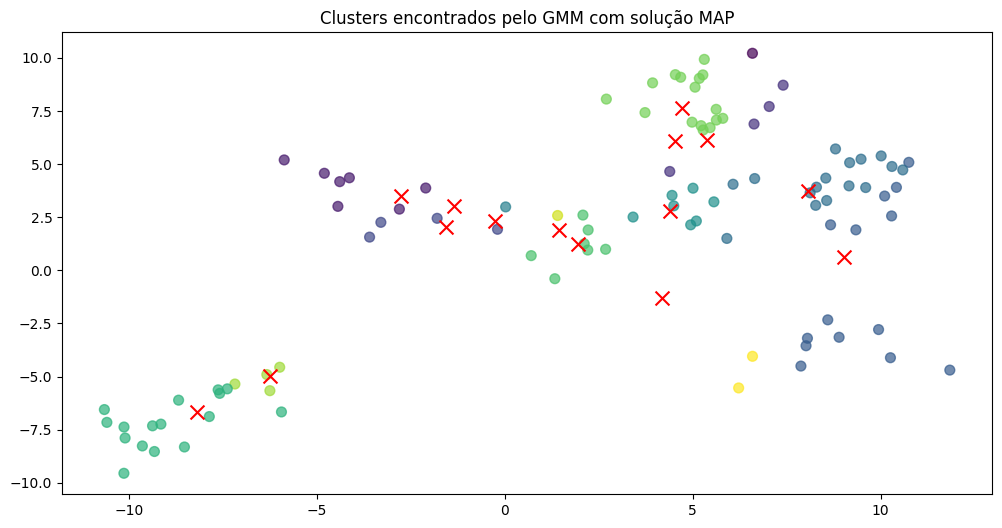

In [41]:

X = np.array(df)

# Criar e ajustar o modelo GMM com solução MAP
gmm_map = GaussianMixtureModelMAP(n_components=15, alpha=1.1)
gmm_map.fit(X)

# Fazer previsões
clusters = gmm_map.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.scatter(gmm_map.mu[:, 0], gmm_map.mu[:, 1], c='red', marker='x', s=100)
plt.title("Clusters encontrados pelo GMM com solução MAP")
plt.show()


Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.
Convergência atingida em 2 iterações.


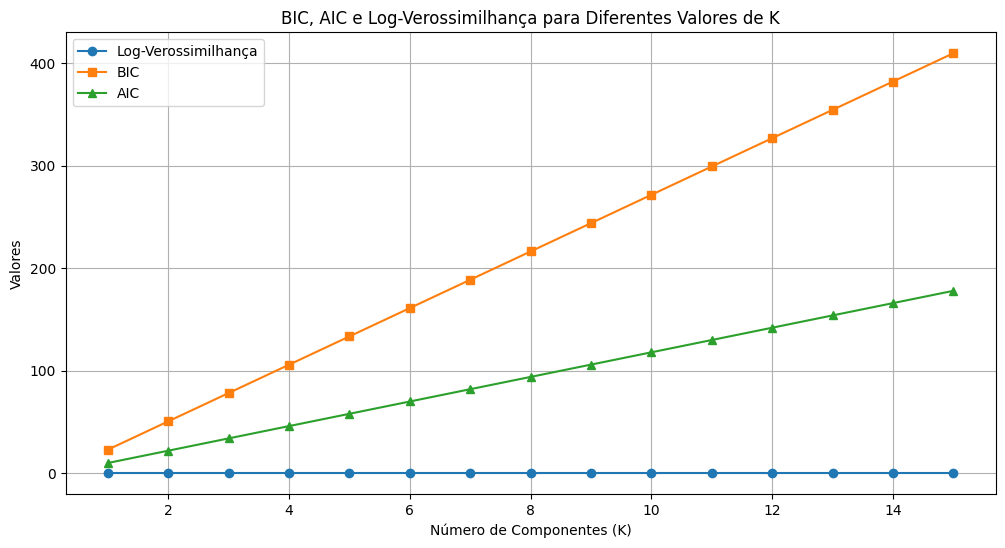

In [31]:

# Avaliar para diferentes números de componentes
max_components = 15
bic_values = []
aic_values = []
log_likelihood_values = []

for k in range(1, max_components + 1):
    gmm = GaussianMixtureModelMAP(n_components=k)
    gmm.fit(X)

    log_likelihood = gmm.log_likelihood
    n_samples, n_features = X.shape
    n_params = k * (n_features + n_features * (n_features + 1) / 2) + k - 1

    bic, aic = calculate_bic_aic(log_likelihood, n_params, n_samples)

    bic_values.append(bic)
    aic_values.append(aic)
    log_likelihood_values.append(log_likelihood)

# Plotar os resultados
plt.figure(figsize=(12, 6))

plt.plot(range(1, max_components + 1), log_likelihood_values, marker='o', label='Log-Verossimilhança')
plt.plot(range(1, max_components + 1), bic_values, marker='s', label='BIC')
plt.plot(range(1, max_components + 1), aic_values, marker='^', label='AIC')

plt.xlabel('Número de Componentes (K)')
plt.ylabel('Valores')
plt.title('BIC, AIC e Log-Verossimilhança para Diferentes Valores de K')
plt.legend()
plt.grid()
plt.show()

In [52]:
# Cálculo de BIC e AIC
bic, aic = gmm_map.calculate_bic_aic(X)
print(f"BIC: {bic}, AIC: {aic}")



BIC: 409.8601465529402, AIC: 178.0


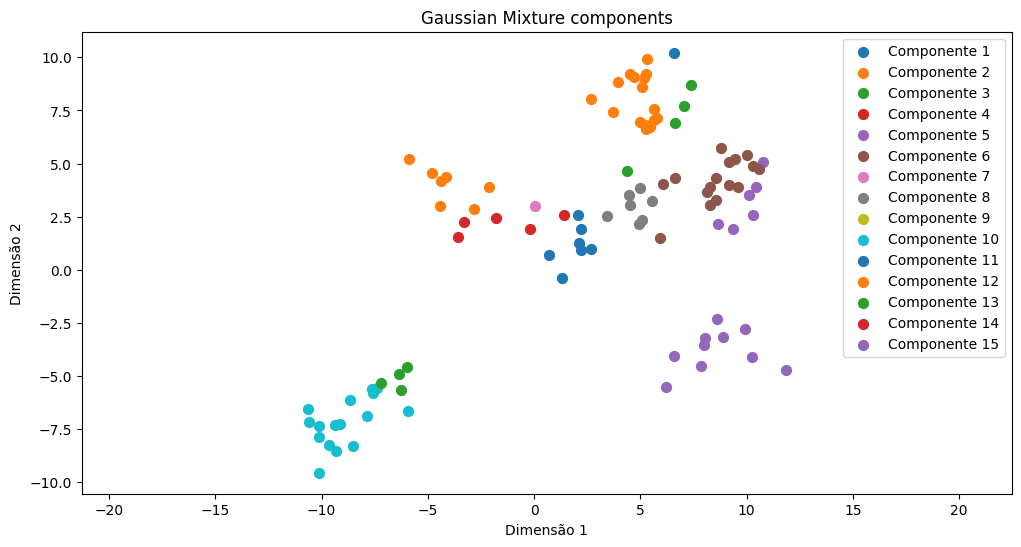

In [42]:
# Plotar os clusters
gmm_map.plot_clusters(X)

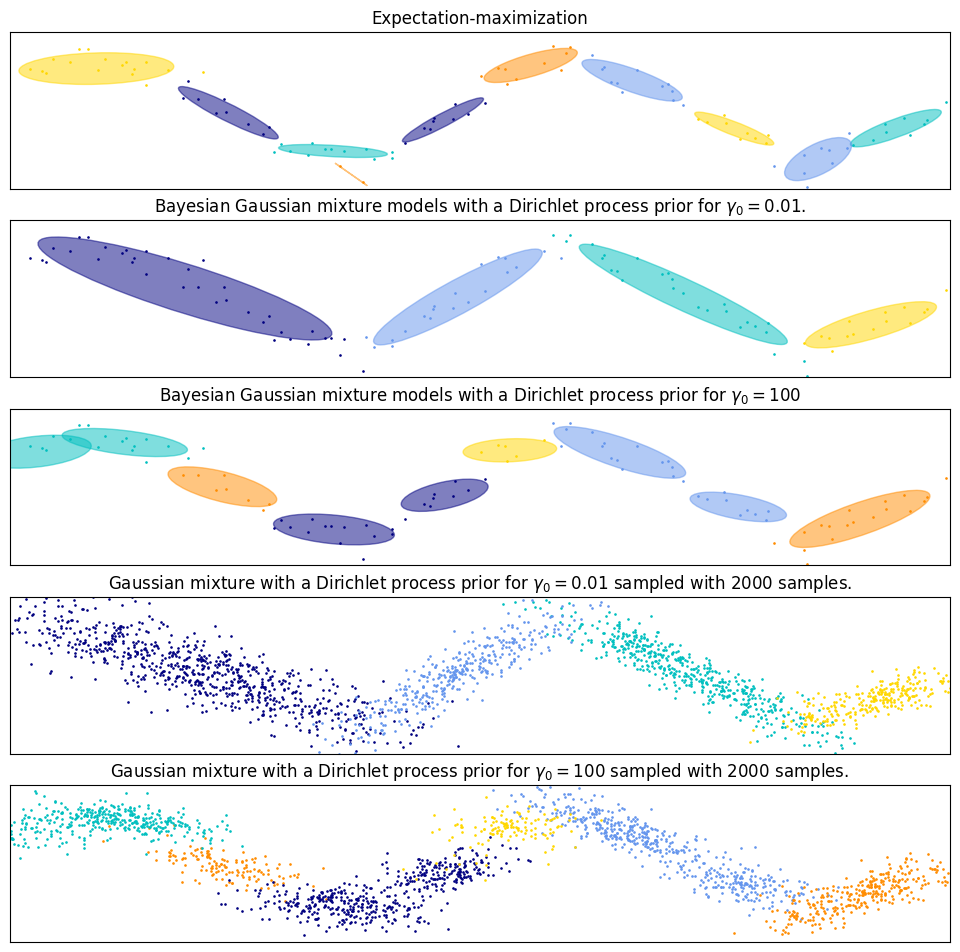

In [50]:
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Parameters
n_samples = df.shape[0]

# Generate random sample following a sine curve
X = np.array(df)
step = 4.0 * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.0
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3.0 * (np.sin(x) + np.random.normal(0, 0.2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(
    bottom=0.04, top=0.95, hspace=0.2, wspace=0.05, left=0.03, right=0.97
)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(
    n_components=10, covariance_type="full", max_iter=100
).fit(X)
plot_results(
    X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Expectation-maximization"
)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e-2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="random",
    max_iter=100,
    random_state=2,
).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=0.01$.",
)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    0,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=0.01$ sampled with $2000$ samples.",
)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="kmeans",
    max_iter=100,
    random_state=2,
).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    2,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=100$",
)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    1,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=100$ sampled with $2000$ samples.",
)

plt.show()


In [45]:
df.shape[0]


100

In [47]:
X

array([[-5.92858197e+00,  1.41994885e-01],
       [-5.86202365e+00,  9.98523925e-01],
       [-5.64704461e+00,  2.21788065e+00],
       [-5.73345340e+00,  2.59011528e+00],
       [-5.38577403e+00,  3.21824841e+00],
       [-5.41925456e+00,  1.19721525e+00],
       [-5.21649260e+00,  2.46421523e+00],
       [-5.35167388e+00,  2.31623668e+00],
       [-4.91057188e+00,  1.98569788e+00],
       [-4.80325069e+00,  3.26830378e+00],
       [-4.57649859e+00,  2.54857052e+00],
       [-4.62210687e+00,  3.59521865e+00],
       [-4.39444373e+00,  3.78540303e+00],
       [-4.44317466e+00,  2.95597710e+00],
       [-4.32391203e+00,  3.84636351e+00],
       [-4.09269130e+00,  2.45543406e+00],
       [-3.95487712e+00,  2.53856556e+00],
       [-3.82982522e+00,  1.74896498e+00],
       [-3.65574921e+00,  6.48459009e-01],
       [-3.64493370e+00,  7.21694155e-01],
       [-3.28253543e+00,  9.74290345e-01],
       [-3.50218300e+00,  1.30839692e+00],
       [-3.39790593e+00,  2.79321959e-01],
       [-3.